# 循环神经网络的从零开始实现
:label:`sec_rnn_scratch`

本节将根据 :numref:`sec_rnn`中的描述，
从头开始基于循环神经网络实现字符级语言模型。
这样的模型将在H.G.Wells的时光机器数据集上训练。
和前面 :numref:`sec_language_model`中介绍过的一样，
我们先读取数据集。


In [52]:
import math
import mlx
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from d2l import mlx as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

def mlx_one_hot(array, num_classes): #@ save
    """Defined in :numref:`sec_rnn-scratch`"""
    original_shape = array.shape
    array = array.reshape((-1,))
    array = array.astype(mx.int32)
    one_hot_matrix = mx.zeros((array.shape[0], num_classes))
    one_hot_matrix[mx.arange(array.shape[0]), array] = 1
    one_hot_matrix = one_hot_matrix.reshape((*original_shape, num_classes))
    return one_hot_matrix
mlx_one_hot(mx.array([0, 2]), len(vocab))

X = mx.arange(10).reshape((2, 5))
one_hot_X = mlx_one_hot(X.T, num_classes=28)

def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return mx.random.normal(shape) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = mx.zeros(num_hiddens)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = mx.zeros(num_outputs)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

def init_rnn_state(batch_size, num_hiddens):
    return (mx.zeros((batch_size, num_hiddens)), )

def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = mx.tanh(mx.matmul(X, W_xh) + mx.matmul(H, W_hh) + b_h)
        Y = mx.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return mx.concatenate(outputs, axis=0), (H,)

class RNNModelRScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = mlx_one_hot(X.T, self.vocab_size).astype(mx.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)
    

num_hiddens = 512
net = RNNModelRScratch(len(vocab), num_hiddens, get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0])

# 这里要传入 X 和 state
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

def predict_ch8(prefix, num_preds, net, vocab):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: mx.array([outputs[-1]]).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # 使用 mx.argmax 并转换为 int
        pred = int(mx.argmax(y, axis=1).item())
        outputs.append(pred)
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab)

'time traveller gqi<unk>vhykmt'

TypeError: grad(): incompatible function arguments. The following argument types are supported:
    1. grad(fun: callable, argnums: Optional[Union[int, List[int]]] = None, argnames: Union[str, List[str]] = []) -> callable

Invoked with types: mlx.core.array, list

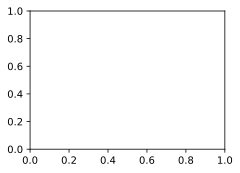

In [55]:

import math
import mlx
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from d2l import mlx as d2l

def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = mx.sqrt(sum(mx.sum(p.grad ** 2) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def backward(loss, params):
    """计算梯度"""
    grads = mx.grad(loss, params)
    for param, grad in zip(params, grads):
        param.grad = grad

#@save
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter, num_classes):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0])
        else:
            # 对于从零开始实现的模型是个张量
            for s in state:
                s[:] = s.detach()
        y = Y.T.reshape((-1,))
        X, y = X.astype(mx.float32), y.astype(mx.float32)
        y_hat, state = net(X, state)
        l = loss(y_hat, y).mean()
        if isinstance(updater, optim.Optimizer):
            updater.zero_grad()
            backward(l, net.params)
            grad_clipping(net, 1)
            updater.step()
        else:
            backward(l, net.params)
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.size, y.size)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


def cross_entropy(y_hat, y, num_classes):
    """自定义的交叉熵损失函数"""
    y_one_hot = mx.zeros((y.size, num_classes))
    y_one_hot[mx.arange(y.size), y.astype(mx.int32)] = 1
    return -mx.sum(y_one_hot * mx.log(y_hat + 1e-8), axis=1).mean()



#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    """训练模型（定义见第8章）"""
    num_classes = len(vocab)
    loss = lambda y_hat, y: cross_entropy(y_hat, y, num_classes)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = nn.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, use_random_iter, num_classes)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒')
    print(predict('time traveller'))
    print(predict('traveller'))


num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs)